## 2D slices extraction
This notebook is used to extract PNG images from MRI files (with nifti format), which will be used to train a convolutional neural network.  

The process is as follows:
   - Load Nifti file
   - Skull stripping
   - Get slices from coronal view
   - Add slices in a 2D picture
   - Save picture

### Initial setup

In [1]:
# Specify if user is working on Google Drive
google_drive = False

In [2]:
if google_drive == True:
    
    from google.colab import drive 
    drive.mount('/content/drive')
    
    path = "./drive/MyDrive/TFM"
    
    import sys
    sys.path.append(path)

else:
    path = "."
    
    import sys
    sys.path.append(path)

#### Google Colab TPU session

In [3]:
# Specify if user is working on a TPU session in Google Colab
tpu_session = False

In [4]:
if tpu_session == True:
    
    %tensorflow_version 2.x
    import tensorflow as tf
    print("Tensorflow version " + tf.__version__)

    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
else:
    pass

### Import libraries

In [5]:
import os
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import cv2

# Neuroimaging packages
import nibabel as nib # Access to neuroimaging data formats
import med2image    # Convert medical images to jpg and png (pip install med2image)
from scipy import ndimage

# Extra utils
from aux_functions.aux_functions_cleaning import *

### Load Nifti files - Extract 2D slices

#### Specify dataset path

In [24]:
# Specify folders where there are the 3D zipped Nifti files of the brain 
root_nifti_files = ["/datasets/Original_zips/ADNI1_Complete_2Yr_1.5T_images/Zip_3",
                    "/datasets/Original_zips/ADNI1_Complete_2Yr_1.5T_images/Zip_4",
                    "/datasets/Original_zips/ADNI1_Complete_2Yr_1.5T_images/Zip_5"]
root_nifti_files = [path + item_ for item_ in root_nifti_files]

In [30]:
# Specify folders where to save the 2D slices in PNG format
root_png_images = path + "/datasets/New_png_images/"

# Check if folder where to save the slices exists. If not, create it.
if not os.path.exists(root_png_images):
    os.mkdir(root_png_images)   

#### Extract 2D slice from each Nitfi file
  - Titles of the 3D nitfi files have this format: *ADNI_137_S_0283_MR_MPR-R__GradWarp__N3__Scaled_Br_20070810182546038_S31798_I67027.nii.gz*
      - Last item **_"I67027"_** of the file name specifies the Image ID, which will be used later on the project.
  - 3D Nitfi files have three planes:
      - 1st axis - **AXIAL**
      - 2nd axis - **CORONAL**
      - 3rd axis - **SAGGITAL**

[+] Folder: {'./datasets/Original_zips/ADNI1_Complete_2Yr_1.5T_images/Zip_3'}
    [-] Number of files in the folder: 129
        ./datasets/New_png_images/I112184.png was already converted to PNG
        0 images converted to PNG
        ./datasets/New_png_images/I121003.png was already converted to PNG
        0 images converted to PNG
        ./datasets/New_png_images/I136698.png was already converted to PNG
        0 images converted to PNG
        ./datasets/New_png_images/I102450.png was already converted to PNG
        0 images converted to PNG
        ./datasets/New_png_images/I104357.png was already converted to PNG
        0 images converted to PNG
        ./datasets/New_png_images/I83334.png was already converted to PNG
        0 images converted to PNG
        ./datasets/New_png_images/I140747.png was already converted to PNG
        0 images converted to PNG
        ./datasets/New_png_images/I124682.png was already converted to PNG
        0 images converted to PNG
        

KeyboardInterrupt: 

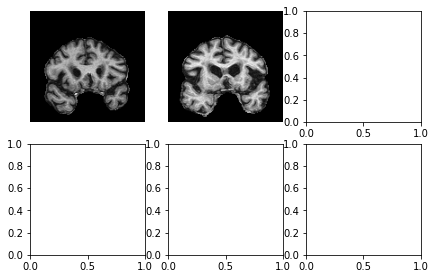

In [33]:
for folder in root_nifti_files:
    
    # Check number of files in the folder
    print(f"[+] Folder:", {folder})
    print(f"    [-] Number of files in the folder:", len(os.listdir(folder)))
    
    count_images = 0  # Initialize images counter
    
    for file in os.listdir(folder):
    
        # Avoid trigerring .DS_Store (when use macOS)
        if file.startswith('.DS_Store'):
            continue

        if file.endswith('.nii.gz'):
            
            # Load Nifti file
            image = nib.load(os.path.join(folder, file))

        # Retrieve Image ID from the 3D nitfi file name
        title = root_png_images + file.split("_")[-1].split(".")[0] + '.png'

        if os.path.exists(title):
            print(f"        {title} was already converted to PNG")
            
        else:
            # Get image with multiple slices and save it in PNG format
            extract_slice(image, title)
            count_images += 1
                
        # Print counter status
        if(count_images % 20 == 0):
            print(f"        {count_images} images converted to PNG")
            

    print(f"    [-] Number of images converted to PNG:", count_images)

### Skull-stripping
Below it can be seen how the skull-stripping process works for each individual Nifti file.

#### Load Nitfi file

In [ ]:
# Specify folders where there are the 3D zipped Nifti file of the brain 
root_nifti_files = path + "/Datasets/Original_zips/ADNI1_Complete_3Yr_1.5T_images"
file = "ADNI_002_S_0295_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20081026123329555_S54061_I123685.nii.gz"

In [ ]:
# Load Nitfi file
image = nib.load(os.path.join(root_nifti_files, file))

# Get image data
data = image.get_fdata()

#### Detect brain mass

In [ ]:
# Initialize brain tissue extractor
ext = Extractor()

# Calculate probability of being brain tissue
prob = ext.run(data) 

# Extract mask with probability higher than 0.5
mask = prob > 0.5

#### Extract slice before & after skull stripping

In [ ]:
# Set-up slice
slice_index  = 109
slice_original = np.array(data[:, slice_index, :])

# Extract slice after skull-stripping 
slice_cleaned = return_clean_slice(slice_original, slice_index, mask, 5)

#### Plot figures with original slice and cleaned slice

In [ ]:
# Set figure
fig, axes = plt.subplots(1, 3, figsize = (10, 8))

# Plot slice before cleaning
axes[0].imshow(slice_original, cmap="gray")
axes[0].set_title('Brain slice')

# Plot brain mass detected
axes[1].imshow(mask[:, slice_index, :], cmap="gray")
axes[1].yaxis.set_visible(False)
axes[1].set_title('Brain mass')

# Plot slice after cleaning
axes[2].imshow(slice_cleaned, cmap="gray")
axes[2].yaxis.set_visible(False)
axes[2].set_title('Cleaned brain slice');

### Extract 3D brain

#### Load Nitfi file

In [ ]:
# Specify folders where there are the 3D zipped Nifti file of the brain 
root_nifti_files = path + "/datasets/"
file = "ADNI_002_S_0295_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070802163833409_S32678_I64025.nii.gz"

In [ ]:
# Load Nitfi file
image = nib.load(os.path.join(root_nifti_files, file))

# Get image data
data = image.get_fdata()

#### Detect brain mass

In [ ]:
# Initialize brain tissue extractor
ext = Extractor()

# Calculate probability of being brain tissue
prob = ext.run(data) 

# Extract mask with probability higher than 0.5
mask = prob > 0.5

#### Remove skull stripping from brain

In [ ]:
brain_cleaned = np.zeros((256,256,166), dtype = "int16")

for index_i, i in enumerate(data):
    for index_j, j in enumerate(i):
        for index_k, k in enumerate(j):
            
            if mask[index_i, index_j, index_k] == True:
                brain_cleaned[index_i, index_j, index_k] = data[index_i, index_j, index_k]

#### Convert brain to Nifti file
The following site can be used to visualize 3D Nifti files  
https://socr.umich.edu/HTML5/BrainViewer/

In [ ]:
nifti_image = nib.Nifti1Image(brain_cleaned, affine=np.eye(4))

In [ ]:
nib.save(nifti_image, "nifti_created_2.nii.gz")  

### Nifti files shapes

(256, 256, 166)
ADNI_002_S_0295_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20081026123329555_S54061_I123685.nii.gz

(166, 256, 256)
ADNI_002_S_1155_MR_MT1__GradWarp__N3m_Br_20120420155919867_S78071_I299371.nii.gz

(160, 192, 192)
ADNI_003_S_1122_MR_MT1__GradWarp__N3m_Br_20120308102241125_S80176_I288891.nii.gz

(256, 256, 170)
ADNI_010_S_0419_MR_MPR____N3__Scaled_Br_20091001170206632_S69112_I155919.nii.gz

(192, 192, 160)
ADNI_011_S_0003_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080124113450407_S39296_I88252.nii.gz

(170, 256, 256)
ADNI_012_S_1133_MR_MT1__N3m_Br_20120308102406161_S84881_I288893.nii.gz

(256, 256, 180)
ADNI_021_S_0141_MR_MPR__GradWarp__N3__Scaled_Br_20090316133310029_S63464_I139026.nii.gz

(256, 256, 184)
ADNI_032_S_0214_MR_MPR____N3__Scaled_Br_20090420150801593_S63793_I142010.nii.gz

(180, 256, 256)
ADNI_116_S_1315_MR_MT1__GradWarp__N3m_Br_20120308104543026_S82700_I288917.nii.gz

(256, 256, 162)
ADNI_136_S_0107_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20091208153924724_S68219_I160555.nii.gz

#### Load Nitfi file

In [ ]:
# Specify folders where there are the 3D zipped Nifti file of the brain 
root_nifti_files = path + "/Datasets/Original_zips/ADNI1_Complete_3Yr_1.5T_images"
file = "ADNI_002_S_1155_MR_MT1__GradWarp__N3m_Br_20120420155919867_S78071_I299371.nii.gz"

In [ ]:
# Load Nitfi file
image = nib.load(os.path.join(root_nifti_files, file))

# Get image data
data = image.get_fdata()

# Print image shape
print(f"[+] Shapes of image loaded:", data.shape)

#### Define slice to print

In [ ]:
# Set-up slice
slice_index  = 60
slice_ = np.array(data[:, slice_index, :])

#### Plot figure with 2D slice

In [ ]:
# Set figure
fig, axes = plt.subplots(1, 2, figsize = (10, 8))

# Plot 2D slice
axes[0].imshow(slice_, cmap="gray")
axes[0].set_title('Brain slice')

rotated_img = ndimage.rotate(slice_, 90)

axes[1].imshow(rotated_img, cmap="gray")
axes[1].set_title('Brain slice rotated');

#### NO ROTATE
(256, 256, 166) - face = 0  - DONE  
(256, 256, 170) - face = 0  
(192, 192, 160) - face = 0  - DONE (un poco justo de abajo)  
(256, 256, 180) - face = 0  
(256, 256, 184) - face = 0  - DONE  
(256, 256, 162) - face = 0  

#### ROTATE
(166, 256, 256) - face = 256  - DONE  
(160, 192, 192) - face = 192  - DONE   
(170, 256, 256) - face = 256  - DONE
(180, 256, 256) - face = 256  

rotated_img = ndimage.rotate(slice_, 90)

### Individual slices

#### Load Nitfi file

In [ ]:
# Specify folders where there are the 3D zipped Nifti file of the brain 
root_nifti_files = path + "/Datasets/Original_zips/ADNI1_Complete_3Yr_1.5T_images"
file = "ADNI_032_S_0214_MR_MPR____N3__Scaled_Br_20090420150801593_S63793_I142010.nii.gz"

In [ ]:
# Load Nitfi file
image = nib.load(os.path.join(root_nifti_files, file))

# Print image shape
print(f"[+] Shapes of image loaded:", image.get_fdata().shape)

#### Extract collection of 2D slices

In [ ]:
extract_slice(image)

In [ ]:
def slices_matrix_2D(img):
    ''' Transform a 3D MRI image into a 2D image, by obtaining 9 slices and placing them in a 4x4 two-dimensional grid.
      
      All 16 cuts are from a horizontal/axial view. They are selected from the 30th to the 60th level of the original 3D image.
      
      Parameters:
        img -- np.ndarray with the 3D image
        
      Returns:
        np.ndarray -- The resulting 2D image
    '''
  
    # create the final 2D image 
    image_2D = np.empty(IMG_2D_SHAPE)
  
    # set the limits and the step
    TOP = 60
    BOTTOM = 30
    STEP = 2
    N_CUTS = 8
  
    # iterator for the cuts
    cut_it = TOP
    # iterator for the rows of the 2D final image
    row_it = 0
    # iterator for the columns of the 2D final image
    col_it = 0
  
    for cutting_time in range(N_CUTS):
    
        # cut
        cut = img[:, cut_it, :]
        cut_it -= STEP
    
        # reset the row iterator and move the
        # col iterator when needed
        if cutting_time in [2, 4, 8]:
            row_it = 0
            col_it += cut.shape[1]
    
        # copy the cut to the 2D image
        for i in range(cut.shape[0]):
            for j in range(cut.shape[1]):
                image_2D[i + row_it, j + col_it] = cut[i, j]
    
        row_it += cut.shape[0]
        print(cutting_time)
  
    # return the final 2D image, with 3 channels
    # this is necessary for working with most pre-trained nets
    return np.repeat(image_2D[None, ...], 3, axis=0).T
    #return image_2D